# Interactive experimentation

In [ ]:
# !pip install --upgrade lightgbm scikit-learn pandas adlfs

## Setup cloud tracking

In [1]:
import mlflow
from azureml.core import Workspace

ws = Workspace.from_config()
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())
mlflow.set_experiment("explain-ml-exp")

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


## Load data

You can read directly from public URIs into Pandas. For private Blob or ADLS data, consider using [adlfs](https://github.com/dask/adlfs).

In [2]:
data_uri = "https://azuremlexamples.blob.core.windows.net/datasets/iris.csv"

In [3]:
import pandas as pd

df = pd.read_csv(data_uri)
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## Define functions

In [4]:
# imports
import time

import lightgbm as lgb

from sklearn.metrics import log_loss, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# define functions
def preprocess_data(df):
    X = df.drop(["species"], axis=1)
    y = df["species"]

    enc = LabelEncoder()
    y = enc.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    return X_train, X_test, y_train, y_test, enc


def train_model(params, num_boost_round, X_train, X_test, y_train, y_test):
    t1 = time.time()
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)
    model = lgb.train(
        params,
        train_data,
        num_boost_round=num_boost_round,
        valid_sets=[test_data],
        valid_names=["test"],
    )
    t2 = time.time()

    return model, t2 - t1


def evaluate_model(model, X_test, y_test):
    y_proba = model.predict(X_test)
    y_pred = y_proba.argmax(axis=1)
    loss = log_loss(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)

    return loss, acc

## Run a trial

In [43]:
# preprocess data
X_train, X_test, y_train, y_test, enc = preprocess_data(df)

# set training parameters
params = {
    # "objective": "multiclass",
    "objective": "multiclass_ova",
    "num_class": 3,
    "learning_rate": 0.1,
    "metric": "multi_logloss",
    "colsample_bytree": 1.0,
    "subsample": 1.0,
    "seed": 42,
}

num_boost_round = 32

# start run
run = mlflow.start_run()

# enable automatic logging
mlflow.lightgbm.autolog()

# train model
model, train_time = train_model(
    params, num_boost_round, X_train, X_test, y_train, y_test
)
mlflow.log_metric("training_time", train_time)

# evaluate model
loss, acc = evaluate_model(model, X_test, y_test)
mlflow.log_metrics({"loss": loss, "accuracy": acc})

# end run
mlflow.end_run()

[LightGBM] [Info] Number of positive: 40, number of negative: 80
[LightGBM] [Info] Number of positive: 41, number of negative: 79
[LightGBM] [Info] Number of positive: 39, number of negative: 81
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 91
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.341667 -> initscore=-0.655876
[LightGBM] [Info] Start training from score -0.655876
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325000 -> initscore=-0.730888
[LightGBM] [Info] Start training from score -0.730888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

## LGBM's own explainability features

In [44]:
print(model.feature_name())
print(model.feature_importance())

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
[ 36  85 156  83]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

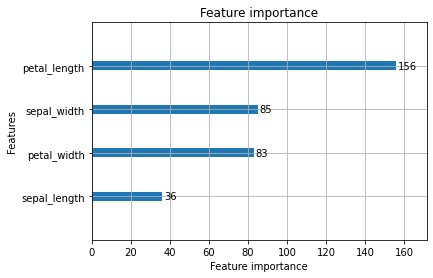

In [45]:
lgb.plot_importance(model)

<AxesSubplot:title={'center':'Split value histogram for feature with index 3'}, xlabel='Feature split value', ylabel='Count'>

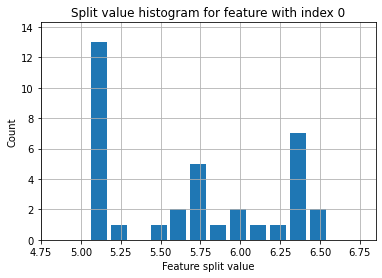

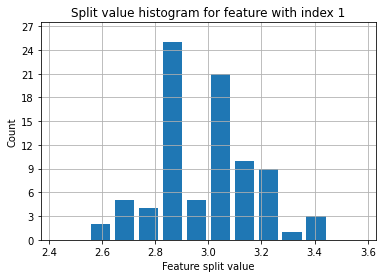

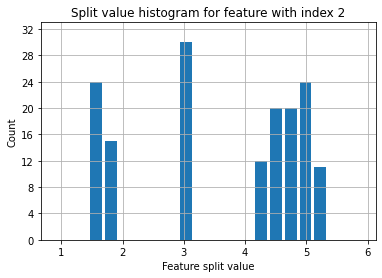

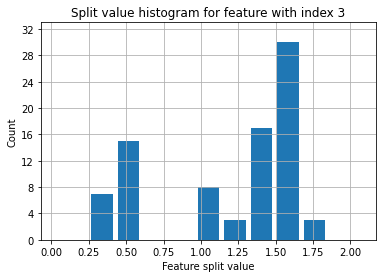

In [46]:
import matplotlib
lgb.plot_split_value_histogram(model, 0)
lgb.plot_split_value_histogram(model, 1)
lgb.plot_split_value_histogram(model, 2)
lgb.plot_split_value_histogram(model, 3)

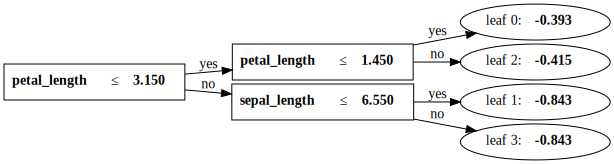

In [47]:
import graphviz
# lgb.plot_tree(model)
lgb.create_tree_digraph(model)

In [32]:
model.params
# blackbox_model = lgb.LGBMClassifier(model)
# blackbox_model.get_params()

{'objective': 'multiclass',
 'num_class': 3,
 'learning_rate': 0.1,
 'metric': 'multi_logloss',
 'colsample_bytree': 1.0,
 'subsample': 1.0,
 'seed': 42,
 'num_iterations': 32,
 'early_stopping_round': None}

## Explain (any blackbox models)

Following steps will require `predict_proba()` so the easiest way would be using `scikit-learn` `Pipeline` to fit the model.
For demo purposes, let's fit the model using Pipeline again.

### Train with scikit-learn pipeline

In [49]:
from sklearn.pipeline import Pipeline

params = {
    # "objective": "multiclass",
    "objective": "multiclass_ova",
    "num_class": 3,
    "learning_rate": 0.1,
    "metric": "multi_logloss",
    "colsample_bytree": 1.0,
    "subsample": 1.0,
    "seed": 42,
}

lgbm_clf = lgb.LGBMClassifier(**params)

blackbox_model = Pipeline([('lgbm_clf', lgbm_clf)])
blackbox_model.fit(X_train, y_train)

Pipeline(steps=[('lgbm_clf',
                 LGBMClassifier(metric='multi_logloss', num_class=3,
                                objective='multiclass_ova', seed=42))])

In [50]:
blackbox_model.get_params()

{'memory': None,
 'steps': [('lgbm_clf',
   LGBMClassifier(metric='multi_logloss', num_class=3, objective='multiclass_ova',
                  seed=42))],
 'verbose': False,
 'lgbm_clf': LGBMClassifier(metric='multi_logloss', num_class=3, objective='multiclass_ova',
                seed=42),
 'lgbm_clf__boosting_type': 'gbdt',
 'lgbm_clf__class_weight': None,
 'lgbm_clf__colsample_bytree': 1.0,
 'lgbm_clf__importance_type': 'split',
 'lgbm_clf__learning_rate': 0.1,
 'lgbm_clf__max_depth': -1,
 'lgbm_clf__min_child_samples': 20,
 'lgbm_clf__min_child_weight': 0.001,
 'lgbm_clf__min_split_gain': 0.0,
 'lgbm_clf__n_estimators': 100,
 'lgbm_clf__n_jobs': -1,
 'lgbm_clf__num_leaves': 31,
 'lgbm_clf__objective': 'multiclass_ova',
 'lgbm_clf__random_state': None,
 'lgbm_clf__reg_alpha': 0.0,
 'lgbm_clf__reg_lambda': 0.0,
 'lgbm_clf__silent': True,
 'lgbm_clf__subsample': 1.0,
 'lgbm_clf__subsample_for_bin': 200000,
 'lgbm_clf__subsample_freq': 0,
 'lgbm_clf__num_class': 3,
 'lgbm_clf__metric':

ROC only supports binary classification, so for multiclass classification, you may want to convert it to one-vs-all.

In [51]:
from interpret import show
from interpret.perf import ROC

blackbox_perf = ROC(blackbox_model.predict_proba).explain_perf(X_test, y_test, name='Blackbox')
show(blackbox_perf)

/home/seokjin/anaconda3/envs/explain_ml/lib/python3.6/site-packages/lightgbm/basic.py:306: UserWarning:

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.



ValueError: multiclass format is not supported

Try LimeTabular. `lime` and `dash` are used.

In [38]:
from interpret.blackbox import LimeTabular
from interpret import show

#Blackbox explainers need a predict function, and optionally a dataset
lime = LimeTabular(predict_fn=blackbox_model.predict_proba, data=X_train, random_state=1)

#Pick the instances to explain, optionally pass in labels if you have them
lime_local = lime.explain_local(X_test[:5], y_test[:5], name='LIME')


/home/seokjin/anaconda3/envs/explain_ml/lib/python3.6/site-packages/lightgbm/basic.py:306: UserWarning:

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.



In [41]:
show(lime_local)

<!-- http://127.0.0.1:7001/140542964589344/ -->